In [96]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Build dataset

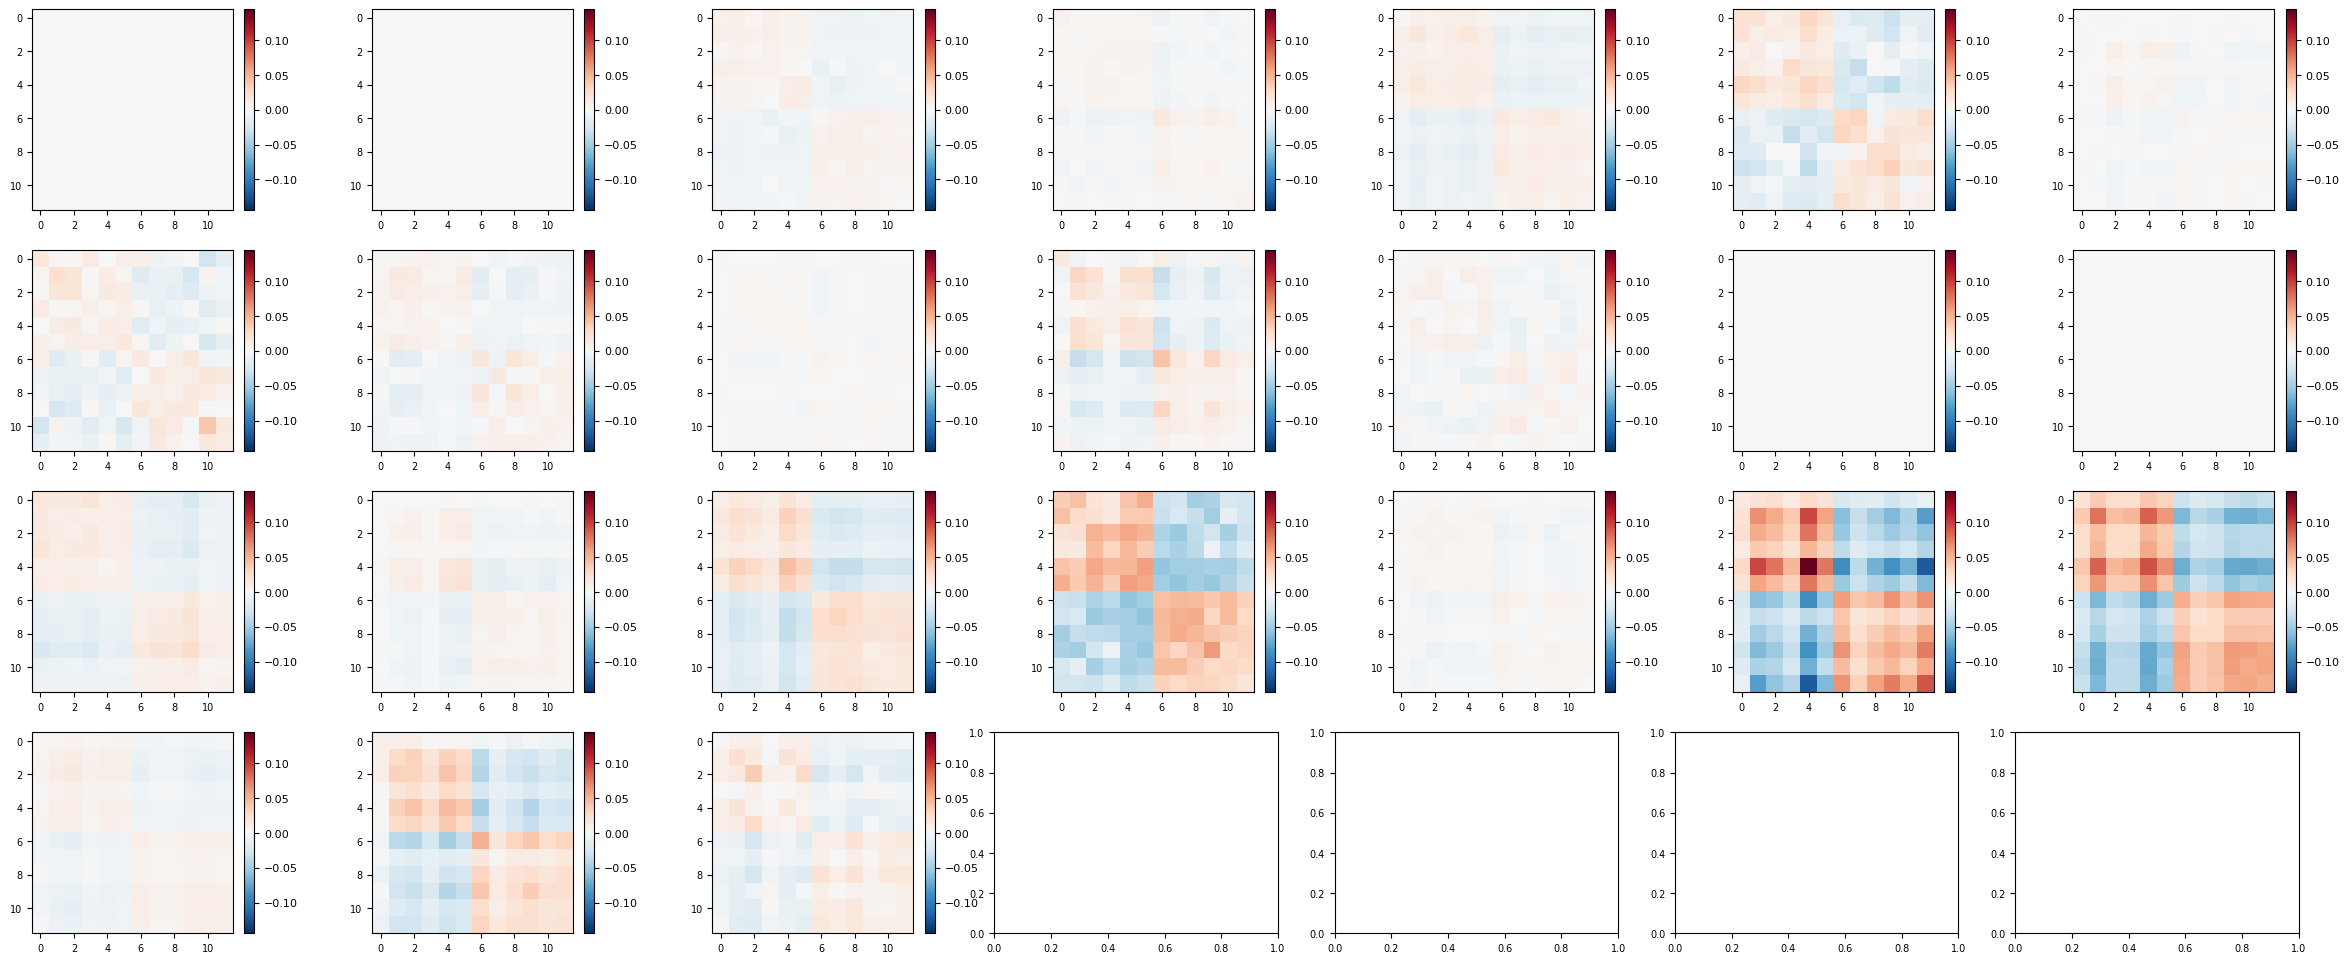

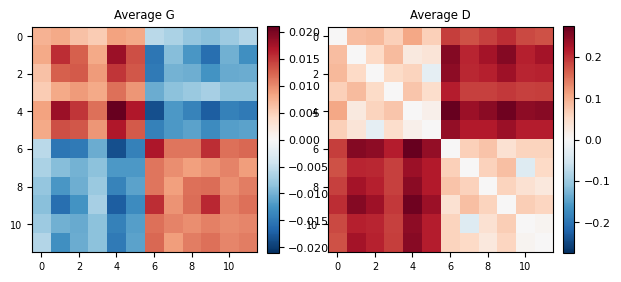

In [97]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']

region = regions[2]
data, cond_vec, part_vec = [], [], []
for i_hem, h in enumerate(hem):
    roi = f'{region}_{h}'
    file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
    d = np.load(file_path, allow_pickle=True)

    subject = d['subject']
    indices = [k for k, s in enumerate(subject) if s not in sn_bad]

    subject = d['subject'][indices]
    cond_name_tmp = d['cond_intrinsic_vec'][indices]
    cond_vec_tmp = d['cond_num_vec'][indices]
    data_tmp = d['beta_white'][indices]
    part_tmp = d['part_vec'][indices]

    for i_sub in range(len(subject)):
        idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
        idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
        idx = idx1 + idx2
        Y = data_tmp[i_sub][idx, :]
        subj_part = part_tmp[i_sub][idx]
        # Sort based on Hemisphere to have contralateral first:
        if h == 'L':
            subj_cond = cond_vec_tmp[i_sub][idx]
            tmp = subj_cond.copy()
            subj_cond[tmp > 5] = tmp[tmp > 5] - 6
            subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
        elif h == 'R':
            subj_cond = cond_vec_tmp[i_sub][idx]

        data.append(Y)
        cond_vec.append(np.array(subj_cond))
        part_vec.append(subj_part)

Y = []
# --- RDM Calculation ---
for i_sub in range(len(data)):
    obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
    Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

N = len(Y)
ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
G_hat = np.zeros((N, ncond, ncond))
for i_sub in range(N):
    G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                Y[i_sub].obs_descriptors['cond_vec'],
                                                Y[i_sub].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

# show all second moment matrices
cmap = 'RdBu_r'
fig,ax = plt.subplots(4,7,figsize=(30,12))
vmax = np.abs(G_hat).max()
for i in range(N):
    ax[i//7,i%7].imshow(G_hat[i,:,:],vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[i//7,i%7], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

# avg:
fig, ax = plt.subplots(1,2,figsize=(7,3))
G_hat_avg = np.mean(G_hat, axis=0)
# G_hat_avg = G_hat_avg / np.trace(G_hat_avg)
vmax = np.abs(G_hat_avg).max()
ax[0].imshow(G_hat_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[0].set_title(f'Average G')

D_avg = pcm.G_to_dist(G_hat_avg)
D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
vmax = np.abs(D_avg).max()
ax[1].imshow(D_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[1].set_title(f'Average D')
plt.show() 




# Build models

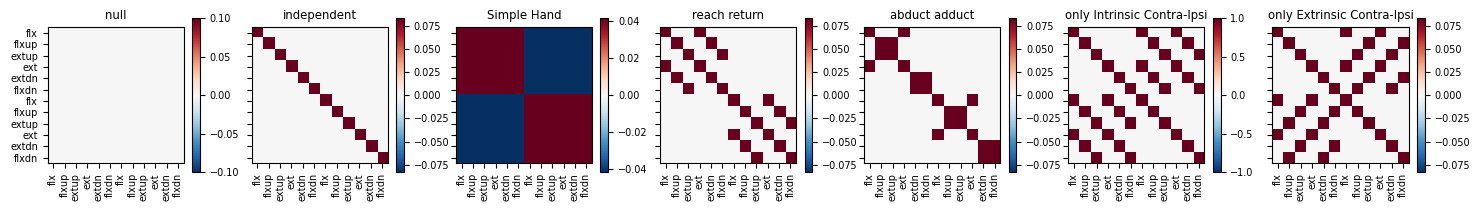

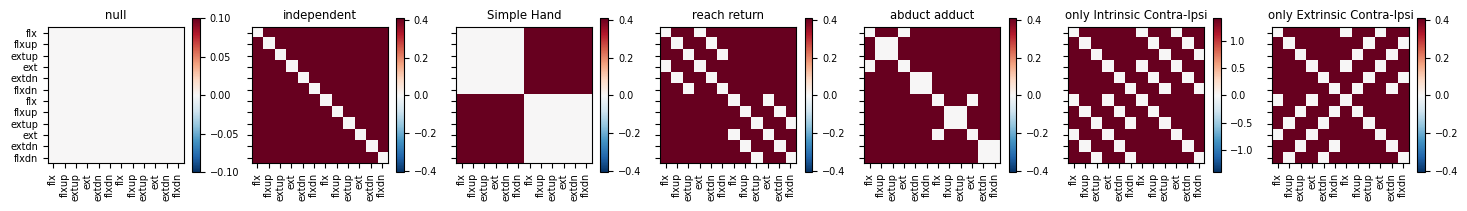

In [ ]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
ncond = 12

M = []
modelG = {}

# ================ Fixed models ================
# Null model - no information:
cov = np.zeros((ncond, ncond))
M_null = pcm.FixedModel('null', cov)
M.append(M_null)

# indepdent model
cov = np.eye(ncond)
cov = cov/np.trace(np.eye(ncond))
M_indep = pcm.FixedModel('independent', cov)
M.append(M_indep)
modelG['independent'] = [cov]

# Which Hand model:
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = 1
cov[6:12, 6:12] = 1
cov = cov / np.trace(cov)
# double center:
cov = cov - np.mean(cov, axis=0) - np.mean(cov, axis=1) + np.mean(cov)
M_hand = pcm.FixedModel('Simple Hand', cov)
M.append(M_hand)
modelG['Simple Hand'] = [cov]

covs = np.tile(np.eye(3), (2,2))
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = covs
cov[6:12, 6:12] = covs
cov = cov / np.trace(cov)
M_contra_ipsi = pcm.FixedModel('reach return', cov)
M.append(M_contra_ipsi)
modelG['reach return'] = [cov]

# abduct - adduct model:
covs = np.eye(6)
covs[0,3] = 1
covs[1,2] = 1
covs[2,1] = 1
covs[3,0] = 1
covs[4,5] = 1
covs[5,4] = 1
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = covs
cov[6:12, 6:12] = covs
cov = cov / np.trace(cov)
M_contra_ipsi = pcm.FixedModel('abduct adduct', cov)
M.append(M_contra_ipsi)
modelG['abduct adduct'] = [cov]

# Intrinsic Contra-Ipsi model:
# cov = modelG['reach return'][0].copy()
cov = np.eye((ncond))
tmp = np.tile(np.eye(3), (2,2))
cov[0:6, 6:12] = tmp
cov[6:12, 0:6] = tmp
# cov = cov / np.trace(cov)
M_intrinsic = pcm.FixedModel('only Intrinsic Contra-Ipsi', cov)
M.append(M_intrinsic)
modelG['Intrinsic Contra-Ipsi'] = [cov]

# Extrinsic Contra-Ipsi model:
cov = np.eye(ncond)
cov[0,6] = 1
cov[0,9] = 1
cov[1,8] = 1
cov[1,11] = 1
cov[2,7] = 1
cov[2,10] = 1
cov[3,6] = 1
cov[3,9] = 1
cov[4,8] = 1
cov[4,11] = 1
cov[5,7] = 1
cov[5,10] = 1
# symmetrize:
cov = cov + cov.T - np.eye(ncond)
cov = cov / np.trace(cov)
M_extrinsic = pcm.FixedModel('only Extrinsic Contra-Ipsi', cov)
M.append(M_extrinsic)
modelG['Extrinsic Contra-Ipsi'] = [cov]

# ================ components models ================
# Simple hand + independent structure:
M.append(pcm.ComponentModel('SimpleHand+Independent', [modelG['Simple Hand'][0], modelG['independent'][0]]))

# Simple hand + independent + reach return structure:
M.append(pcm.ComponentModel('SimpleHand+independent+ReachReturn', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['reach return'][0]]))

# Simple hand + independent + abduct adduct structure:
M.append(pcm.ComponentModel('SimpleHand+independent+AbductAdduct', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['abduct adduct'][0]]))

# Simple hand + independent + Intrinsic structure:
M.append(pcm.ComponentModel('SimpleHand+independent+Intrinsic', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['Intrinsic Contra-Ipsi'][0]]))

# Simple hand + independent + Extrinsic structure:
M.append(pcm.ComponentModel('SimpleHand+independent+Extrinsic', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['Extrinsic Contra-Ipsi'][0]]))

# Simple hand + independent + reach return + abduct adduct structure:
M.append(pcm.ComponentModel('SimpleHand+independent+ReachReturn+AbductAdduct', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['reach return'][0], modelG['abduct adduct'][0]]))

# Simple hand + independent + reach return + abduct adduct + Intrinsic:
M.append(pcm.ComponentModel('SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['reach return'][0], modelG['abduct adduct'][0], modelG['Intrinsic Contra-Ipsi'][0]]))

# Simple hand + independent + reach return + abduct adduct + Extrinsic:
M.append(pcm.ComponentModel('SimpleHand+independent+ReachReturn+AbductAdduct+Extrinsic', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['reach return'][0], modelG['abduct adduct'][0], modelG['Extrinsic Contra-Ipsi'][0]]))

# all models:
M.append(pcm.ComponentModel('SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic+Extrinsic', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['reach return'][0], modelG['abduct adduct'][0], modelG['Intrinsic Contra-Ipsi'][0], modelG['Extrinsic Contra-Ipsi'][0]]))

# ================ noise ceiling ================
# noise ceiling model:
# M_ceil = pcm.model.FreeModel('ceil',ncond)
# # RDMs = pd.read_pickle(os.path.join(analysisDir, 'RDMs_unimanual.pkl'))
# # RDMs = RDMs[(RDMs['region']==region) & (RDMs['hem']=='L')]
# # RDMs = RDMs.G.values
# # G_avg = np.zeros((ncond,ncond))
# # for tmp in RDMs:
# #     G_avg += tmp/len(RDMs)
# # M_ceil = pcm.FixedModel('ceil', G_avg)
# M.append(M_ceil)

# PLOT:
nmodels = len(M)
fix, ax = plt.subplots(1,7, figsize=(18,2), sharey=True)
for i in range(7):
    vmin = -np.max(np.abs(M[i].G))
    vmax = np.max(np.abs(M[i].G))
    ax[i].imshow(M[i].G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(M[i].G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()

fix, ax = plt.subplots(1,7, figsize=(18,2), sharey=True)
for i in range(7):
    D = pcm.G_to_dist(M[i].G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()




# Fit model

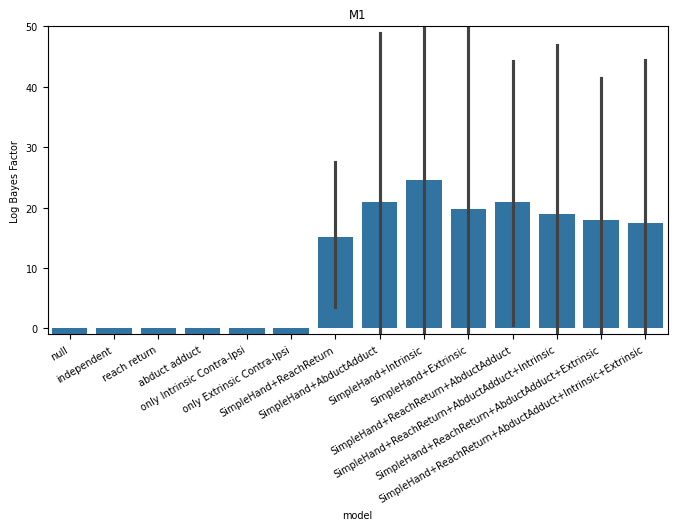

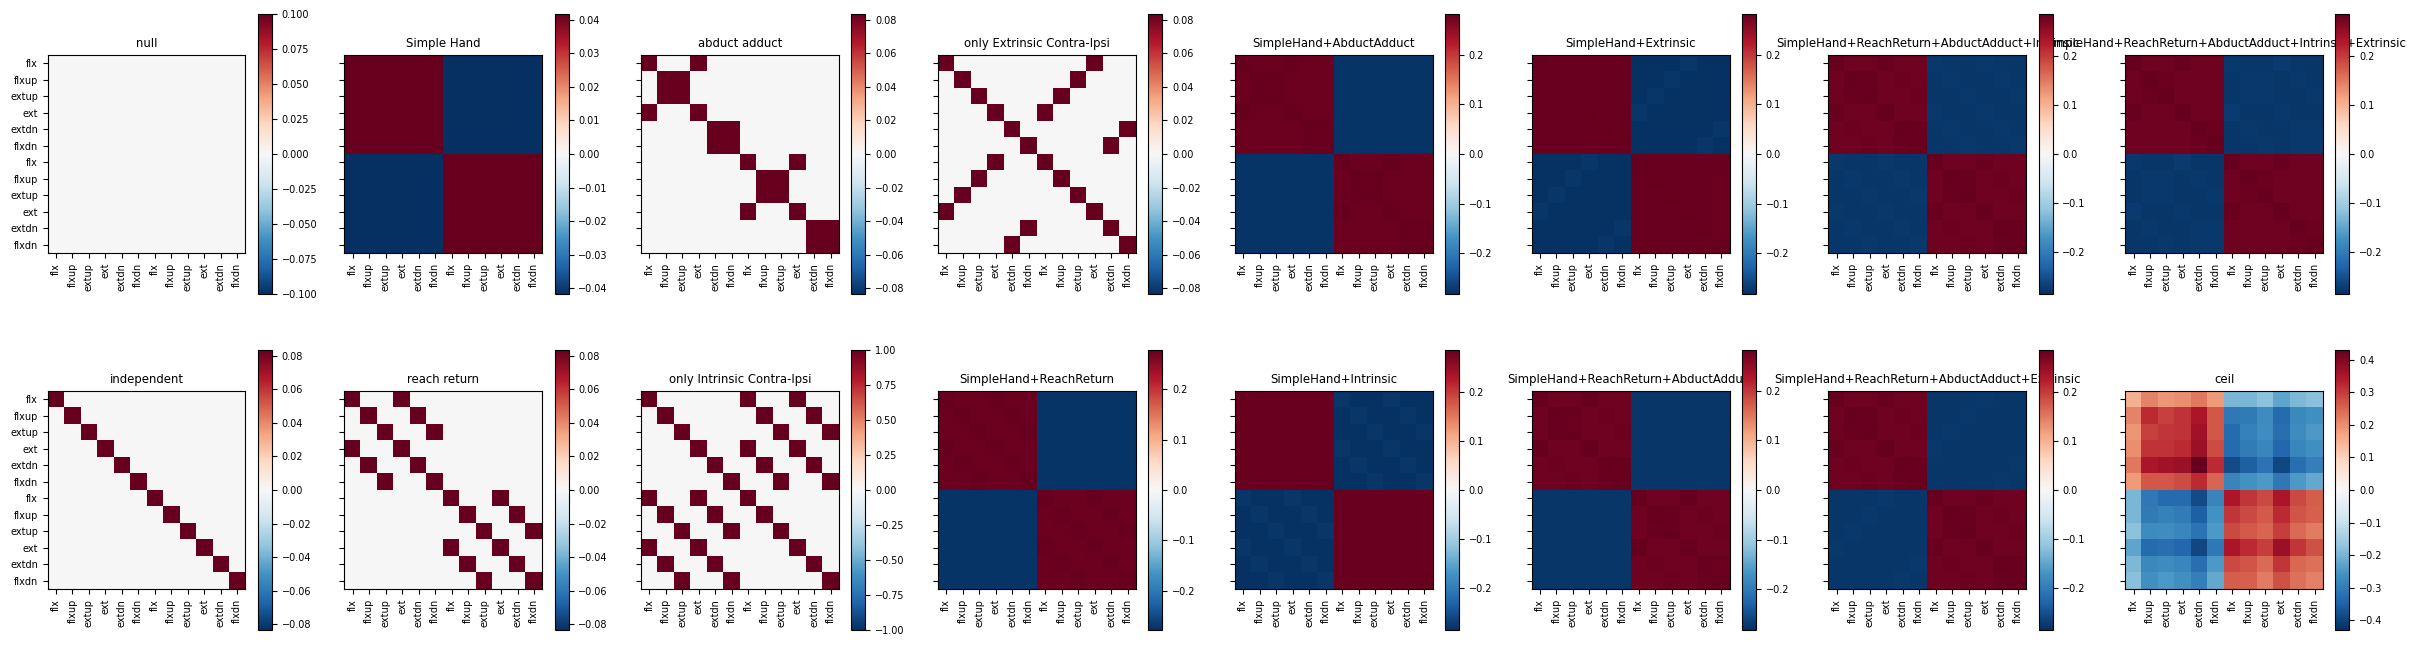

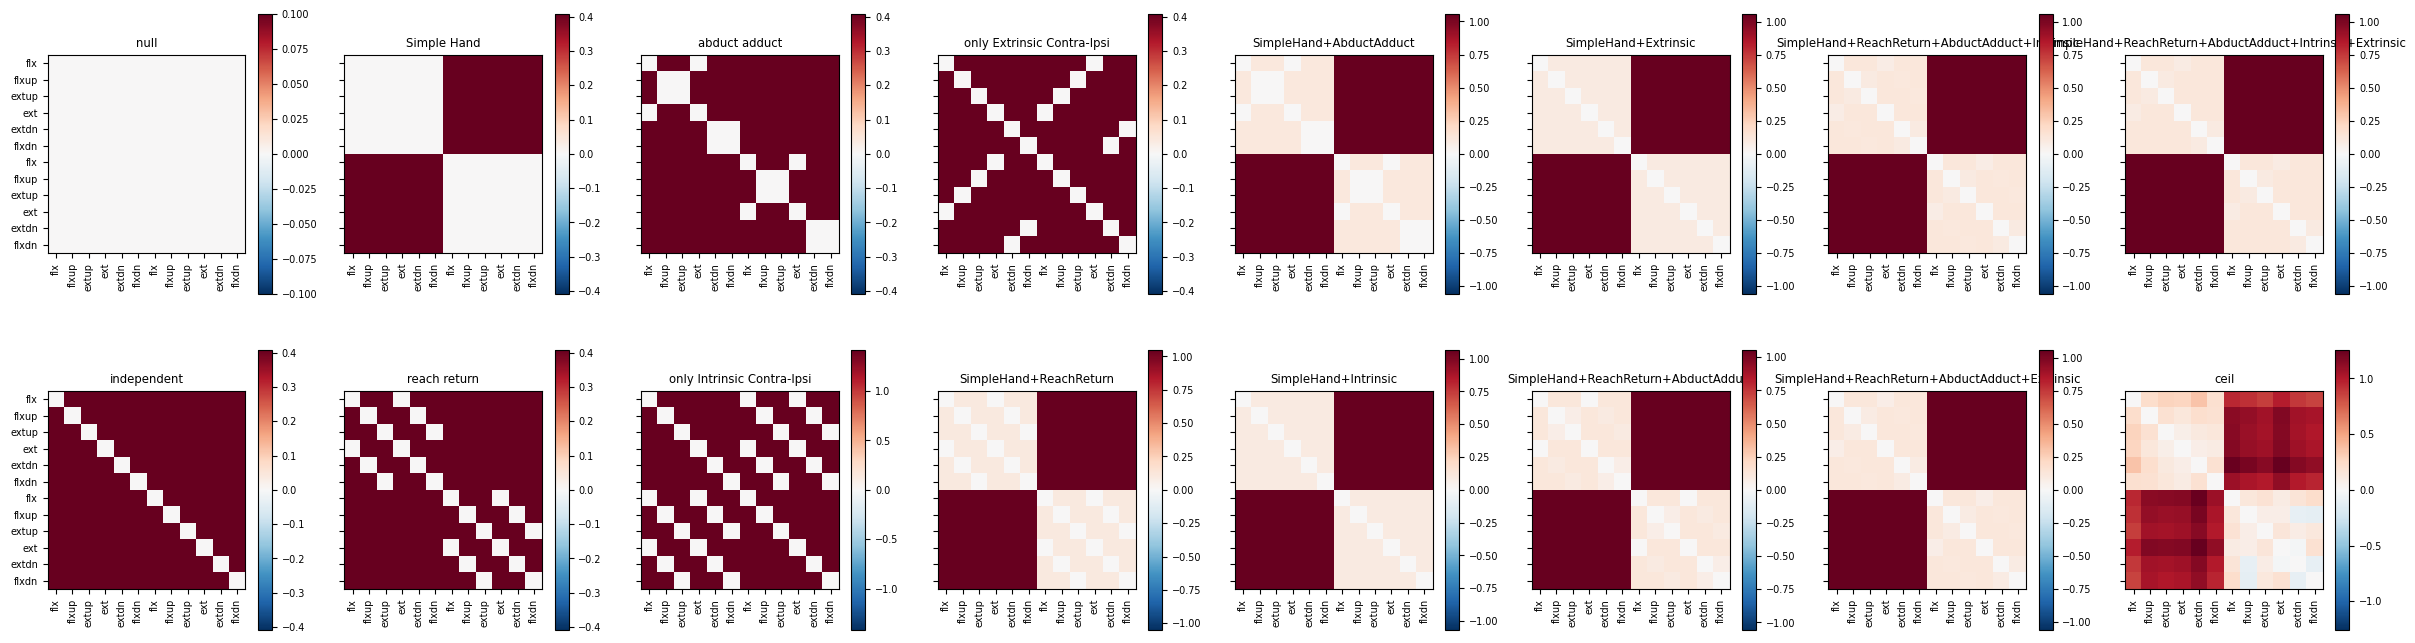

In [201]:
import pickle

region = 'M1'
plt.rcParams.update({'font.size': 7})

name = f'{region}'
# load model fitting:
with open(os.path.join(analysisDir, f'PCM_12by12_{name}.pkl'), 'rb') as f:
    results = pickle.load(f)

T_gr = results['T_gr']
theta_gr = results['theta_gr']
nmodels = len(theta_gr)

T_cv = results['T_cv']
theta_cv = results['theta_cv']
fig, ax = plt.subplots(1,1,figsize=(8,4))
tmp_ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'Simple Hand',
                        noise_ceiling= 'ceil')
# angle the x axis labels:
plt.xticks(rotation=30, ha='right')
plt.title(f'{name}')
ax.set_ylim(-1, 50)
plt.show()

# Plot model predictions:
fig, ax = plt.subplots(2, nmodels//2, figsize=(30,8), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i%2, i//2].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i%2, i//2].set_title(M[i].name)
    ax[i%2, i//2].set_xticks(list(range(12)))
    ax[i%2, i//2].set_xticklabels(labels, rotation=90)
    ax[i%2, i//2].set_yticks(list(range(12)))
    ax[i%2, i//2].set_yticklabels(labels)
    plt.colorbar(ax[i%2, i//2].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i%2, i//2])
plt.show()

fig, ax = plt.subplots(2,nmodels//2, figsize=(30,8), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    D = pcm.G_to_dist(G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i%2, i//2].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i%2, i//2].set_title(M[i].name)
    ax[i%2, i//2].set_xticks(list(range(12)))
    ax[i%2, i//2].set_xticklabels(labels, rotation=90)
    ax[i%2, i//2].set_yticks(list(range(12)))
    ax[i%2, i//2].set_yticklabels(labels)
    plt.colorbar(ax[i%2, i//2].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i%2, i//2])
plt.show()




# fit all regions

In [ ]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['S1','M1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L', 'R']

for region in regions:
    # MAKE DATASET
    data, cond_vec, part_vec = [], [], []
    for i_hem, h in enumerate(hem):
        roi = f'{region}_{h}'
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
            idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
            idx = idx1 + idx2
            Y = data_tmp[i_sub][idx, :]
            subj_part = part_tmp[i_sub][idx]
            # Sort based on Hemisphere to have contralateral first:
            if h == 'L':
                subj_cond = cond_vec_tmp[i_sub][idx]
                tmp = subj_cond.copy()
                subj_cond[tmp > 5] = tmp[tmp > 5] - 6
                subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
            elif h == 'R':
                subj_cond = cond_vec_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

    # BUILD MODELS:
    labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
    labels_lateral = ['contra']*6 + ['ipsi']*6
    ncond = 12

    M = []
    modelG = {}

    # ================ Fixed models ================
    # Null model - no information:
    cov = np.zeros((ncond, ncond))
    M_null = pcm.FixedModel('null', cov)
    M.append(M_null)

    # indepdent model
    cov = np.eye(ncond)
    cov = cov/np.trace(np.eye(ncond))
    M_indep = pcm.FixedModel('independent', cov)
    M.append(M_indep)
    modelG['independent'] = [cov]

    # Which Hand model:
    cov = np.zeros((ncond, ncond))
    cov[0:6, 0:6] = 1
    cov[6:12, 6:12] = 1
    cov = cov / np.trace(cov)
    # double center:
    cov = cov - np.mean(cov, axis=0) - np.mean(cov, axis=1) + np.mean(cov)
    M_hand = pcm.FixedModel('Simple Hand', cov)
    M.append(M_hand)
    modelG['Simple Hand'] = [cov]

    covs = np.tile(np.eye(3), (2,2))
    cov = np.zeros((ncond, ncond))
    cov[0:6, 0:6] = covs
    cov[6:12, 6:12] = covs
    cov = cov / np.trace(cov)
    M_contra_ipsi = pcm.FixedModel('reach return', cov)
    M.append(M_contra_ipsi)
    modelG['reach return'] = [cov]

    # abduct - adduct model:
    covs = np.eye(6)
    covs[0,3] = 1
    covs[1,2] = 1
    covs[2,1] = 1
    covs[3,0] = 1
    covs[4,5] = 1
    covs[5,4] = 1
    cov = np.zeros((ncond, ncond))
    cov[0:6, 0:6] = covs
    cov[6:12, 6:12] = covs
    cov = cov / np.trace(cov)
    M_contra_ipsi = pcm.FixedModel('abduct adduct', cov)
    M.append(M_contra_ipsi)
    modelG['abduct adduct'] = [cov]

    # Intrinsic Contra-Ipsi model:
    # cov = modelG['reach return'][0].copy()
    cov = np.eye((ncond))
    tmp = np.tile(np.eye(3), (2,2))
    cov[0:6, 6:12] = tmp
    cov[6:12, 0:6] = tmp
    # cov = cov / np.trace(cov)
    M_intrinsic = pcm.FixedModel('only Intrinsic Contra-Ipsi', cov)
    M.append(M_intrinsic)
    modelG['Intrinsic Contra-Ipsi'] = [cov]

    # Extrinsic Contra-Ipsi model:
    cov = np.eye(ncond)
    cov[0,6] = 1
    cov[0,9] = 1
    cov[1,8] = 1
    cov[1,11] = 1
    cov[2,7] = 1
    cov[2,10] = 1
    cov[3,6] = 1
    cov[3,9] = 1
    cov[4,8] = 1
    cov[4,11] = 1
    cov[5,7] = 1
    cov[5,10] = 1
    # symmetrize:
    cov = cov + cov.T - np.eye(ncond)
    cov = cov / np.trace(cov)
    M_extrinsic = pcm.FixedModel('only Extrinsic Contra-Ipsi', cov)
    M.append(M_extrinsic)
    modelG['Extrinsic Contra-Ipsi'] = [cov]

    # ================ components models ================
    # Simple hand + independent structure:
    M.append(pcm.ComponentModel('SimpleHand+Independent', [modelG['Simple Hand'][0], modelG['independent'][0]]))

    # Simple hand + independent + reach return structure:
    M.append(pcm.ComponentModel('SimpleHand+independent+ReachReturn', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['reach return'][0]]))

    # Simple hand + independent + abduct adduct structure:
    M.append(pcm.ComponentModel('SimpleHand+independent+AbductAdduct', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['abduct adduct'][0]]))

    # Simple hand + independent + Intrinsic structure:
    M.append(pcm.ComponentModel('SimpleHand+independent+Intrinsic', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['Intrinsic Contra-Ipsi'][0]]))

    # Simple hand + independent + Extrinsic structure:
    M.append(pcm.ComponentModel('SimpleHand+independent+Extrinsic', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['Extrinsic Contra-Ipsi'][0]]))

    # Simple hand + independent + reach return + abduct adduct structure:
    M.append(pcm.ComponentModel('SimpleHand+independent+ReachReturn+AbductAdduct', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['reach return'][0], modelG['abduct adduct'][0]]))

    # Simple hand + independent + reach return + abduct adduct + Intrinsic:
    M.append(pcm.ComponentModel('SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['reach return'][0], modelG['abduct adduct'][0], modelG['Intrinsic Contra-Ipsi'][0]]))

    # Simple hand + independent + reach return + abduct adduct + Extrinsic:
    M.append(pcm.ComponentModel('SimpleHand+independent+ReachReturn+AbductAdduct+Extrinsic', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['reach return'][0], modelG['abduct adduct'][0], modelG['Extrinsic Contra-Ipsi'][0]]))

    # all models:
    M.append(pcm.ComponentModel('SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic+Extrinsic', [modelG['Simple Hand'][0], modelG['independent'][0], modelG['reach return'][0], modelG['abduct adduct'][0], modelG['Intrinsic Contra-Ipsi'][0], modelG['Extrinsic Contra-Ipsi'][0]]))

    # ================ noise ceiling ================
    # noise ceiling model:
    M_ceil = pcm.model.FreeModel('ceil',ncond)
    # RDMs = pd.read_pickle(os.path.join(analysisDir, 'RDMs_unimanual.pkl'))
    # RDMs = RDMs[(RDMs['region']==region) & (RDMs['hem']=='L')]
    # RDMs = RDMs.G.values
    # G_avg = np.zeros((ncond,ncond))
    # for tmp in RDMs:
    #     G_avg += tmp/len(RDMs)
    # M_ceil = pcm.FixedModel('ceil', G_avg)
    M.append(M_ceil)

    # FIT MODELS:
    import time
    start_time = time.time()
    T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True, verbose=1)
    end_time = time.time()
    print(f"Elapsed time GR: {end_time - start_time:.2f} seconds")

    start_time = time.time()
    T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True, verbose=1)
    end_time = time.time()
    print(f"Elapsed time CV: {end_time - start_time:.2f} seconds")

    # save the results:
    import pickle
    import time
    results = {
            'T_gr': T_gr, 'theta_gr': theta_gr,
            'T_cv': T_cv, 'theta_cv': theta_cv
            }
    with open(os.path.join(analysisDir, f'PCM_12by12_{region}.pkl'), 'wb') as f:
        pickle.dump(results, f)





# Plot

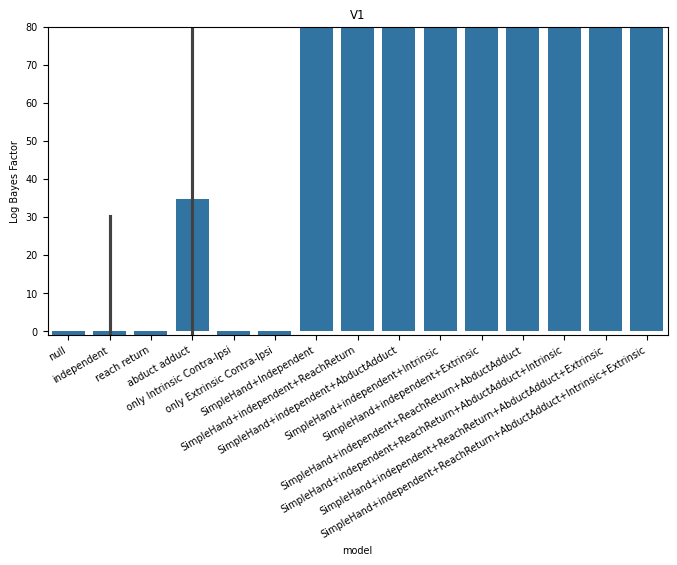

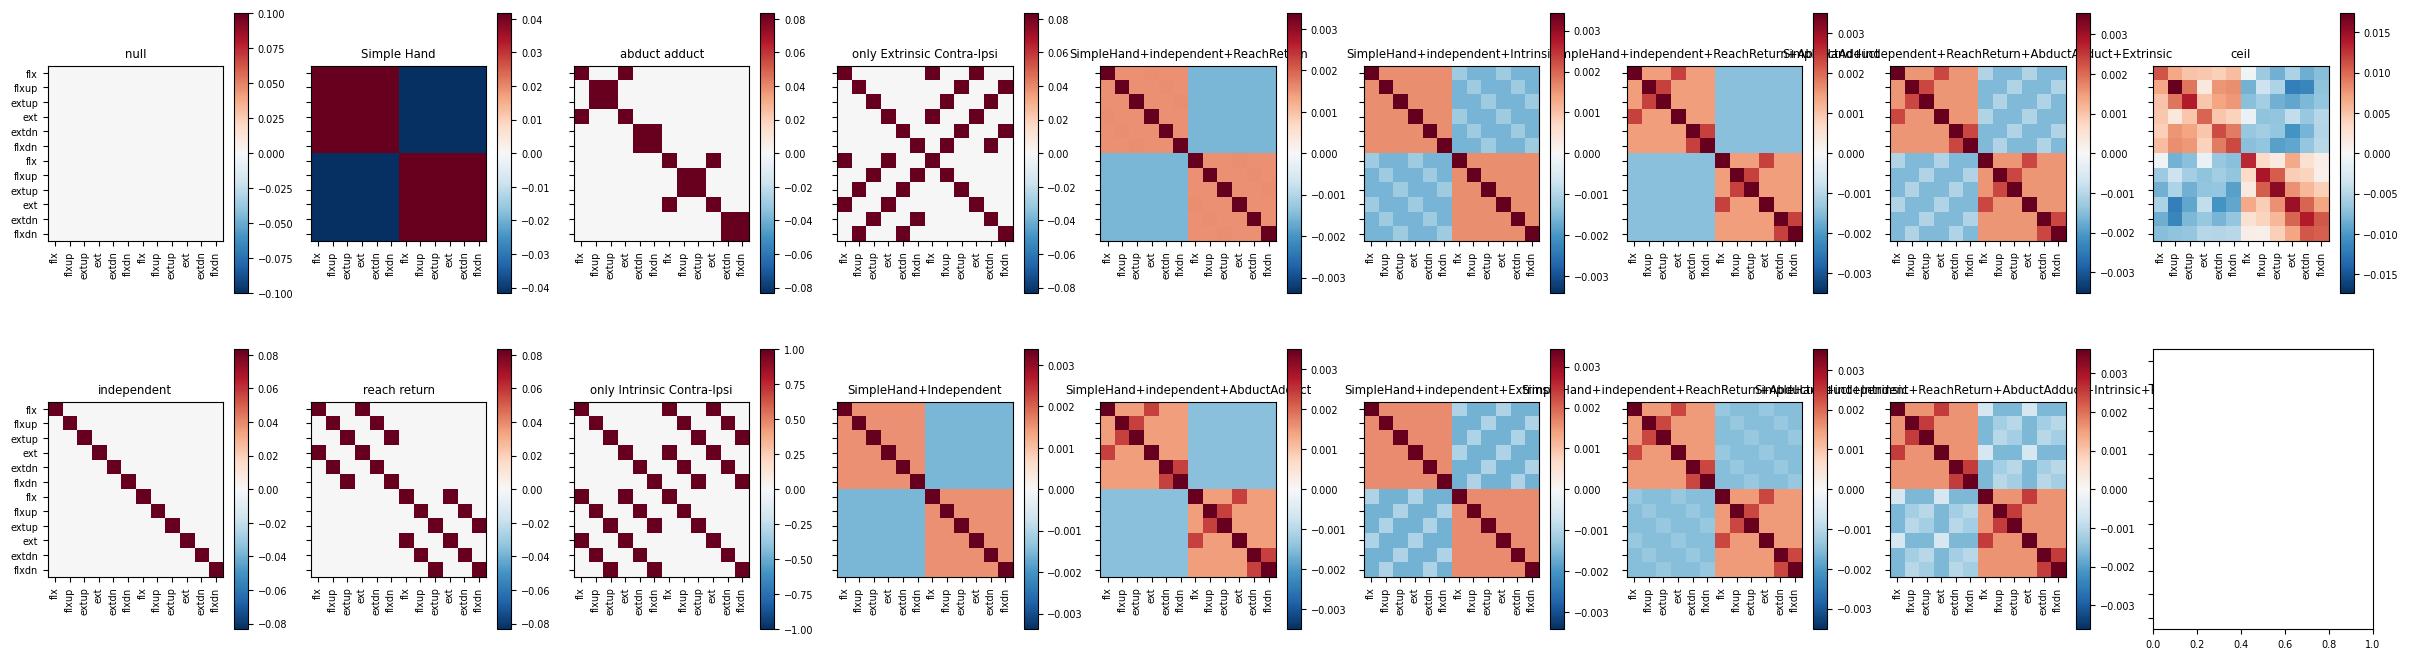

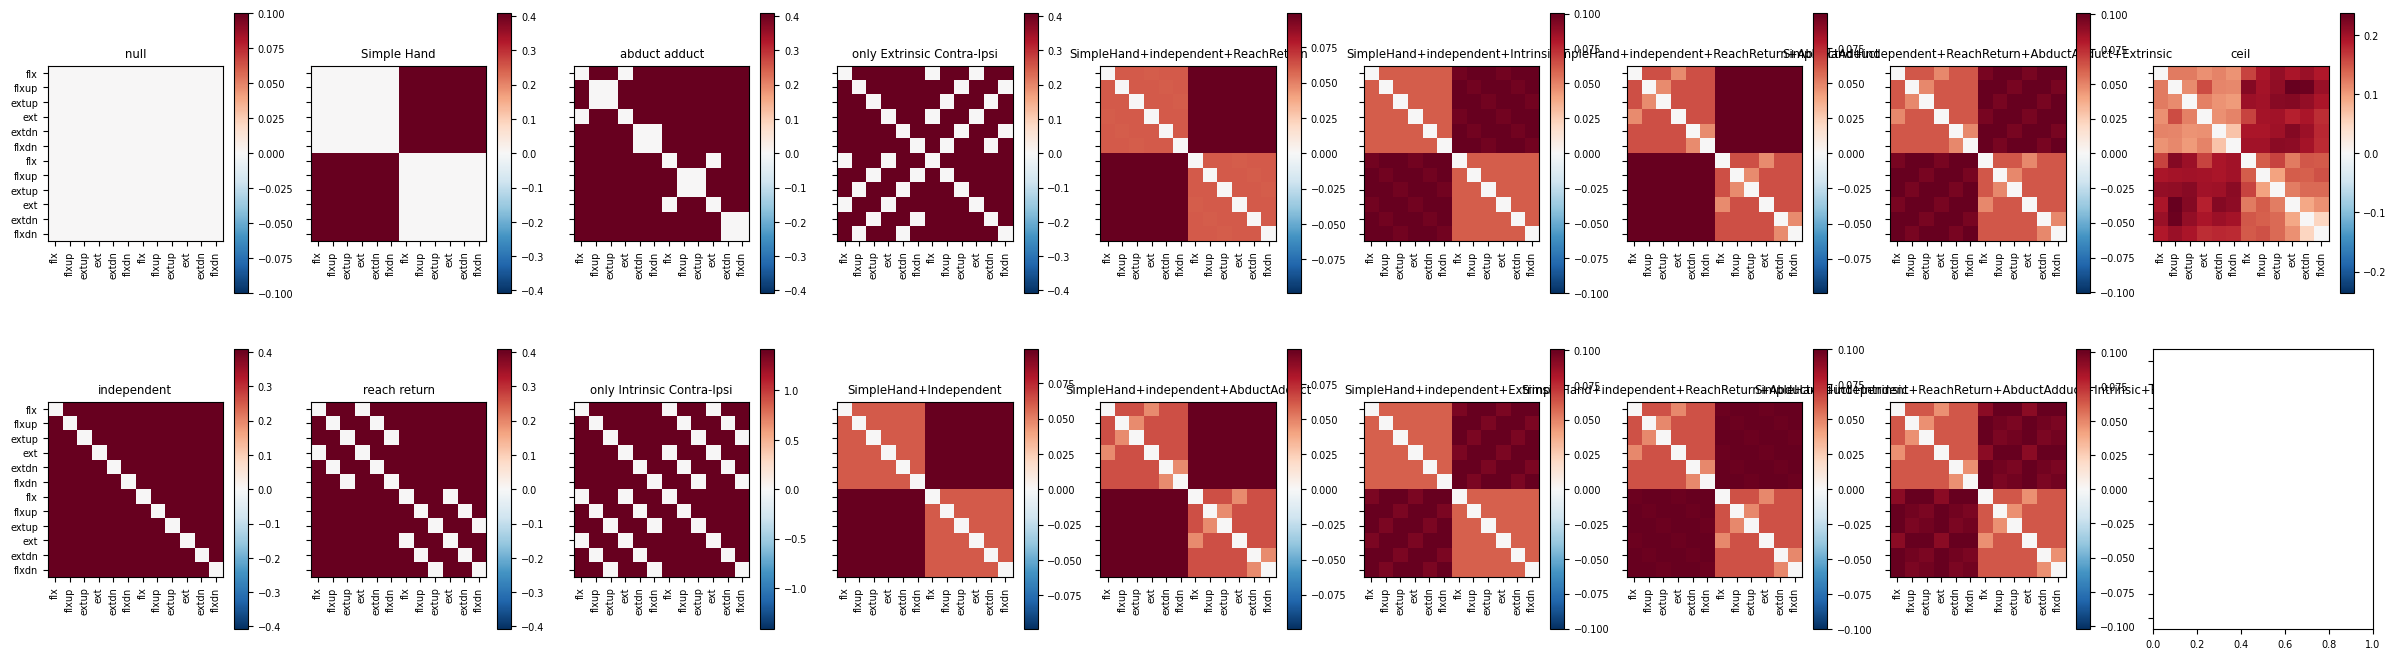

In [60]:
import pickle

region = 'V1'
plt.rcParams.update({'font.size': 7})

name = f'{region}'
# load model fitting:
with open(os.path.join(analysisDir, f'PCM_12by12_{name}.pkl'), 'rb') as f:
    results = pickle.load(f)

T_gr = results['T_gr']
theta_gr = results['theta_gr']
nmodels = len(theta_gr)

T_cv = results['T_cv']
theta_cv = results['theta_cv']
fig, ax = plt.subplots(1,1,figsize=(8,4))
tmp_ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'Simple Hand',
                        noise_ceiling= 'ceil')
# angle the x axis labels:
plt.xticks(rotation=30, ha='right')
plt.title(f'{name}')
ax.set_ylim(-1, 80)
plt.show()

# Plot model predictions:
fig, ax = plt.subplots(2, nmodels//2+1, figsize=(30,8), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i%2, i//2].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i%2, i//2].set_title(M[i].name)
    ax[i%2, i//2].set_xticks(list(range(12)))
    ax[i%2, i//2].set_xticklabels(labels, rotation=90)
    ax[i%2, i//2].set_yticks(list(range(12)))
    ax[i%2, i//2].set_yticklabels(labels)
    plt.colorbar(ax[i%2, i//2].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i%2, i//2])
plt.show()

fig, ax = plt.subplots(2,nmodels//2+1, figsize=(30,8), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    D = pcm.G_to_dist(G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i%2, i//2].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i%2, i//2].set_title(M[i].name)
    ax[i%2, i//2].set_xticks(list(range(12)))
    ax[i%2, i//2].set_xticklabels(labels, rotation=90)
    ax[i%2, i//2].set_yticks(list(range(12)))
    ax[i%2, i//2].set_yticklabels(labels)
    plt.colorbar(ax[i%2, i//2].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i%2, i//2])
plt.show()




# T-Test

In [61]:
# load model fits:
import pickle
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'V1'
name = f'{region}'
# load model fitting:
with open(os.path.join(analysisDir, f'PCM_12by12_{name}.pkl'), 'rb') as f:
    results = pickle.load(f)

T_gr = results['T_gr']
theta_gr = results['theta_gr']
nmodels = len(theta_gr)
T_cv = results['T_cv']
theta_cv = results['theta_cv']

# T-test between models:
from scipy import stats
likelihood = T_cv.likelihood
m_names = likelihood.columns.values
baseline = likelihood.loc[:,'Simple Hand'].values
likelihood = likelihood - baseline.reshape(-1,1)

bayesfact = {'SimpleHand+independent': [], 'SimpleHand+independent+ReachReturn': [], 'SimpleHand+independent+AbductAdduct': [], 'SimpleHand+independent+Intrinsic': [], 'SimpleHand+independent+Extrinsic': [], 'SimpleHand+independent+ReachReturn+AbductAdduct': [], 'SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic': [], 'SimpleHand+independent+ReachReturn+AbductAdduct+Extrinsic': [], 'SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic+Extrinsic': []}
bayesfact['SimpleHand+independent'] = likelihood['SimpleHand+Independent'].values
bayesfact['SimpleHand+independent+ReachReturn'] = likelihood['SimpleHand+independent+ReachReturn'].values
bayesfact['SimpleHand+independent+AbductAdduct'] = likelihood['SimpleHand+independent+AbductAdduct'].values
bayesfact['SimpleHand+independent+Intrinsic'] = likelihood['SimpleHand+independent+Intrinsic'].values
bayesfact['SimpleHand+independent+Extrinsic'] = likelihood['SimpleHand+independent+Extrinsic'].values
bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct'] = likelihood['SimpleHand+independent+ReachReturn+AbductAdduct'].values
bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic'] = likelihood['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic'].values
bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Extrinsic'] = likelihood['SimpleHand+independent+ReachReturn+AbductAdduct+Extrinsic'].values
bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic+Extrinsic'] = likelihood['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic+Extrinsic'].values

# ttest each model >0:
ttests = {}
for k in bayesfact.keys():
    t, p = stats.ttest_1samp(bayesfact[k], 0, alternative='greater')
    mean = np.mean(bayesfact[k])
    std = np.std(bayesfact[k])
    sem = stats.sem(bayesfact[k])
    ttests[k] = {'t': t, 'p': p, 'dof': len(bayesfact[k])-1, 'mean': mean, 'std': std, 'sem': sem}
    print(f'{k}: t({ttests[k]["dof"]})={t:.2f}, p={p:.4f}, mean={mean:.2f} std={std:.2f} sem={sem:.2f}')

# Model comparisons:
t, p = stats.ttest_rel(bayesfact['SimpleHand+independent+Intrinsic'], bayesfact['SimpleHand+independent'], alternative='greater')
mean_diff = np.mean(bayesfact['SimpleHand+independent+Intrinsic'] - bayesfact['SimpleHand+independent'])
std_diff = np.std(bayesfact['SimpleHand+independent+Intrinsic'] - bayesfact['SimpleHand+independent'])
sem_diff = stats.sem(bayesfact['SimpleHand+independent+Intrinsic'] - bayesfact['SimpleHand+independent'])
dof = len(bayesfact['SimpleHand+independent+Intrinsic']) - 1
print('\nModel comparison:')
print(f'Paired t-test indep+Intrinsic > indep: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

t, p = stats.ttest_rel(bayesfact['SimpleHand+independent+Extrinsic'], bayesfact['SimpleHand+independent'], alternative='greater')
mean_diff = np.mean(bayesfact['SimpleHand+independent+Extrinsic'] - bayesfact['SimpleHand+independent'])
std_diff = np.std(bayesfact['SimpleHand+independent+Extrinsic'] - bayesfact['SimpleHand+independent'])
sem_diff = stats.sem(bayesfact['SimpleHand+independent+Extrinsic'] - bayesfact['SimpleHand+independent'])
dof = len(bayesfact['SimpleHand+independent+Extrinsic']) - 1
print(f'Paired t-test indep+Extrinsic > indep: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

t, p = stats.ttest_rel(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic'], bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct'], alternative='greater')
mean_diff = np.mean(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic'] - bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct'])
std_diff = np.std(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic'] - bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct'])
sem_diff = stats.sem(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic'] - bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct'])
dof = len(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic']) - 1
print(f'Paired t-test full_within+Intrinsic vs full_within: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

t, p = stats.ttest_rel(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Extrinsic'], bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct'], alternative='greater')
mean_diff = np.mean(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Extrinsic'] - bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct'])
std_diff = np.std(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Extrinsic'] - bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct'])
sem_diff = stats.sem(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Extrinsic'] - bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct'])
dof = len(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Extrinsic']) - 1
print(f'Paired t-test full_within+Extrinsic vs full_within: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

t, p = stats.ttest_rel(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic+Extrinsic'], bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct'], alternative='greater')
mean_diff = np.mean(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic+Extrinsic'] - bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct'])
std_diff = np.std(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic+Extrinsic'] - bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct'])
sem_diff = stats.sem(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic+Extrinsic'] - bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct'])
dof = len(bayesfact['SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic+Extrinsic']) - 1
print(f'Paired t-test full_within+Intrinsic+Extrinsic vs full_within: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')




SimpleHand+independent: t(23)=4.94, p=0.0000, mean=384.10 std=372.84 sem=77.74
SimpleHand+independent+ReachReturn: t(23)=4.91, p=0.0000, mean=382.07 std=372.82 sem=77.74
SimpleHand+independent+AbductAdduct: t(23)=4.74, p=0.0000, mean=433.78 std=439.33 sem=91.61
SimpleHand+independent+Intrinsic: t(23)=5.00, p=0.0000, mean=399.38 std=383.08 sem=79.88
SimpleHand+independent+Extrinsic: t(23)=4.83, p=0.0000, mean=421.97 std=419.32 sem=87.43
SimpleHand+independent+ReachReturn+AbductAdduct: t(23)=4.74, p=0.0000, mean=433.78 std=439.33 sem=91.61
SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic: t(23)=4.80, p=0.0000, mean=437.66 std=437.25 sem=91.17
SimpleHand+independent+ReachReturn+AbductAdduct+Extrinsic: t(23)=4.67, p=0.0001, mean=460.70 std=473.03 sem=98.63
SimpleHand+independent+ReachReturn+AbductAdduct+Intrinsic+Extrinsic: t(23)=4.72, p=0.0000, mean=477.20 std=484.37 sem=101.00

Model comparison:
Paired t-test indep+Intrinsic > indep: t(23)=2.89, p=0.0042, mean_diff=15.28 std_dif

# Independent Feature Model

build models

In [ ]:
M = []

# centering matrix:
C = pcm.matrix.centering(12)

# which hand reached:
F1 = np.zeros((12, 13))
F1[0:6, 0] = 1  # contra
F1[6: , 0] = 0  # ipsi
F1 = C @ F1

# Contralateral hand
F2 = np.zeros((12, 13))
F2[0:6, 1:7] = np.eye(6)
F2 = C @ F2

# Ipsilateral hand
F3 = np.zeros((12, 13))
F3[6: , 7:13] = np.eye(6)
F3 = C @ F3

# Intrinsic interaction:
F4 = np.zeros((12, 13))
F4[0:6, 7:13] = np.eye(6)
F4 = C @ F4

# Extrinsic interaction:
F5 = np.zeros((12, 13))
F5[0,10] = 1
F5[1,9] = 1
F5[2,8] = 1
F5[3,7] = 1
F5[4,12] = 1
F5[5,11] = 1
F5 = C @ F5

# Data Driven Feature:
ceil_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_unimanual_CVceiling_{region}.pkl'))
ceil = pcm.FreeModel('ceil',6)
params = ceil_fit['theta_cv'][0]
params = np.mean(params[0:21, :], axis=1)
G_ceil = ceil.predict(params)[0]
Ac = np.linalg.cholesky(G_ceil)
F2_data = np.zeros((12,13))
F2_data[0:6, 1:7] = Ac

F3_data = np.zeros((12,13))
F3_data[6: , 7:13] = Ac

# ====================== MAKE MODELS ======================

# Null model:
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = 1
cov[6:12, 6:12] = 1
cov = cov / np.trace(cov)
M_null = pcm.FixedModel('null', cov)
M.append(M_null)

# Make feature model:
A1 = np.stack([F1, F2, F3], axis=0)
M.append(pcm.model.FeatureModel('independent', A1))

A2 = np.stack([F1, F2, F3, F4], axis=0)
M.append(pcm.model.FeatureModel('independent+Intrinsic', A2))

A3 = np.stack([F1, F2, F3, F5], axis=0)
M.append(pcm.model.FeatureModel('independent+Extrinsic', A3))

A4 = np.stack([F1, F2, F3, F4, F5], axis=0)
M.append(pcm.model.FeatureModel('independent+Intrinsic+Extrinsic', A4))

# Data Driven Feature Model:
A5 = np.stack([F1, F2_data, F3_data], axis=0)
M.append(pcm.model.FeatureModel('independent + data', A5))

A6 = np.stack([F1, F2_data, F3_data, F4], axis=0)
M.append(pcm.model.FeatureModel('independent + data + Intrinsic', A6))

A7 = np.stack([F1, F2_data, F3_data, F5], axis=0)
M.append(pcm.model.FeatureModel('independent + data + Extrinsic', A7))

# FIT Models:
# fit model:
T_gr, theta_gr = pcm.fit_model_group(Y, M, fixed_effect='block', fit_scale=True, verbose=True)
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fixed_effect='block', fit_scale=True, verbose=True)



Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


plot

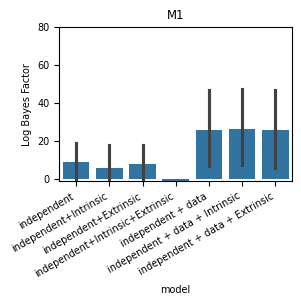

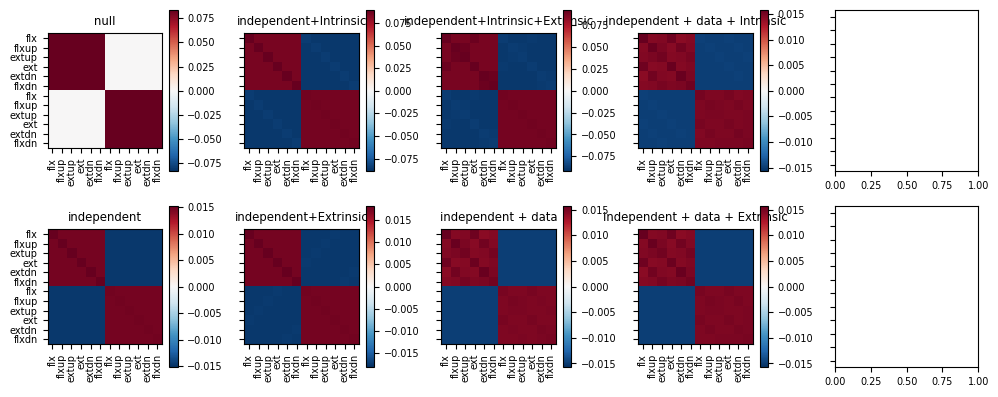

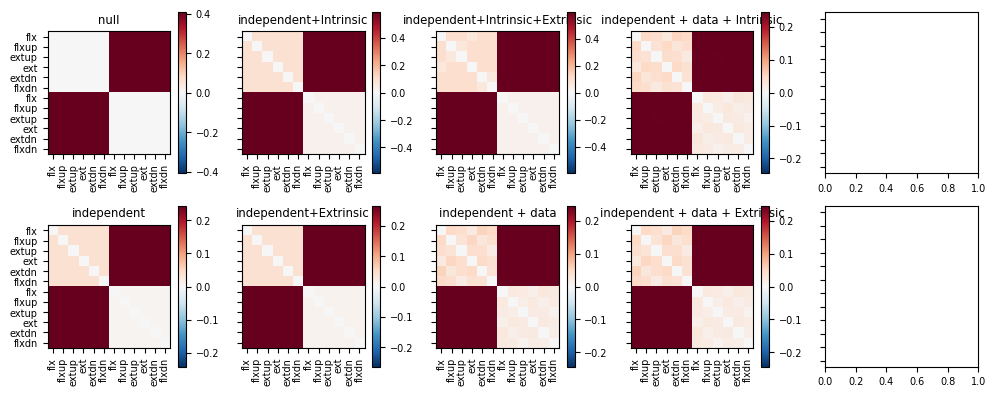

In [94]:
fig, ax = plt.subplots(1,1,figsize=(3,2))
tmp_ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null')
# angle the x axis labels:
plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
ax.set_ylim(-1, 80)
plt.show()

nmodels = len(M)
# Plot model predictions:
fig, ax = plt.subplots(2, nmodels//2+1, figsize=(10,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i%2, i//2].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i%2, i//2].set_title(M[i].name)
    ax[i%2, i//2].set_xticks(list(range(12)))
    ax[i%2, i//2].set_xticklabels(labels, rotation=90)
    ax[i%2, i//2].set_yticks(list(range(12)))
    ax[i%2, i//2].set_yticklabels(labels)
    plt.colorbar(ax[i%2, i//2].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i%2, i//2])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2,nmodels//2+1, figsize=(10,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    D = pcm.G_to_dist(G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i%2, i//2].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i%2, i//2].set_title(M[i].name)
    ax[i%2, i//2].set_xticks(list(range(12)))
    ax[i%2, i//2].set_xticklabels(labels, rotation=90)
    ax[i%2, i//2].set_yticks(list(range(12)))
    ax[i%2, i//2].set_yticklabels(labels)
    plt.colorbar(ax[i%2, i//2].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i%2, i//2])
plt.tight_layout()
plt.show()



# Feature Model

In [61]:
def plot_features(model):
    num_feature = model.Ac.shape[0]
    fig, ax = plt.subplots(1, num_feature, figsize=(2*num_feature, 2))
    for i in range(num_feature):
        ax[i].imshow(model.Ac[i], cmap='RdBu_r', vmin=-np.max(np.abs(model.Ac[i])), vmax=np.max(np.abs(model.Ac[i])))
        ax[i].set_title(f'Feature Set {i+1}')

    fig, ax = plt.subplots(1, num_feature, figsize=(2*num_feature, 2))
    for i in range(num_feature):
        Gtmp = model.Ac[i] @ model.Ac[i].T
        ax[i].imshow(Gtmp, cmap='RdBu_r', vmin=-np.max(np.abs(Gtmp)), vmax=np.max(np.abs(Gtmp)))
        ax[i].set_title(f'Feature Set {i+1} (G)')
    plt.show()
    

Rank of Ac: 6


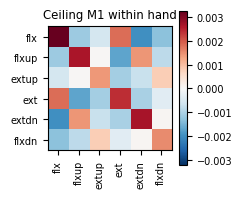

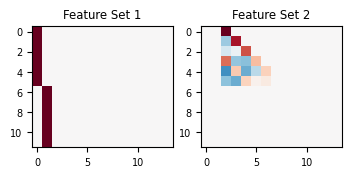

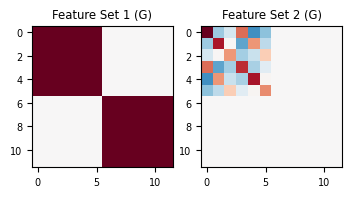

Fitting group model 0
Fitting group model 1
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1


In [85]:
M = []
ncond = 12

# Null model:
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = 1
cov[6:12, 6:12] = 1
cov = cov / np.trace(cov)
# double center:
Mnull = pcm.FixedModel('null', cov)
M.append(Mnull)

# load within-hand CV ceil:
import pickle
ceil_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_unimanual_CVceiling_{region}.pkl'))
ceil = pcm.FreeModel('ceil',6)
params = ceil_fit['theta_cv'][0]
params = np.mean(params[0:21, :], axis=1)
G_ceil = ceil.predict(params)[0]
vmin = -np.max(np.abs(G_ceil))
vmax = np.max(np.abs(G_ceil))
plt.rcParams.update({'font.size': 7})
fig, ax = plt.subplots(1,1, figsize=(2,2))
ax.imshow(G_ceil, cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_title(f'Ceiling {region} within hand')
ax.set_xticks(list(range(6)))
ax.set_xticklabels(labels[0:6], rotation=90)
ax.set_yticks(list(range(6)))
ax.set_yticklabels(labels[0:6])
plt.colorbar(ax.imshow(G_ceil, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax)

# MAKE FEATURE SET:
# decompose G_ceil into feature vector:
Ac = np.linalg.cholesky(G_ceil)
# is Ac full rank?
rank = np.linalg.matrix_rank(Ac)
print(f'Rank of Ac: {rank}')

# Basic hand feature:
A1 = np.zeros((12,14))
A1[0:6, 0] = 1
A1[6: , 0] = 0
A1[0:6, 1] = 0
A1[6: , 1] = 1

# Within-contra feature:
A2 = np.zeros((12,14))
A2[0:6, 2:8] = Ac

# within-ipsi feature:
A3 = np.zeros((12,14))
A3[6: , 8:14] = Ac

# PCM Feature, append along a new axis to make (feature_sets, conds, features)
A = np.stack([A1, A2], axis=0)
A.shape
M1 = pcm.FeatureModel('feature_model',A)
plot_features(M1)
M.append(M1)

# MAKE FEATURE SET 2:


# noise ceiling model:
# M_ceil = pcm.model.FreeModel('ceil',ncond)
# M.append(M_ceil)

T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True, verbose=1)
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True, verbose=1)
nmodels = len(theta_gr)



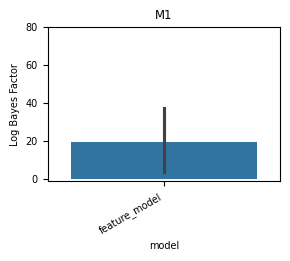

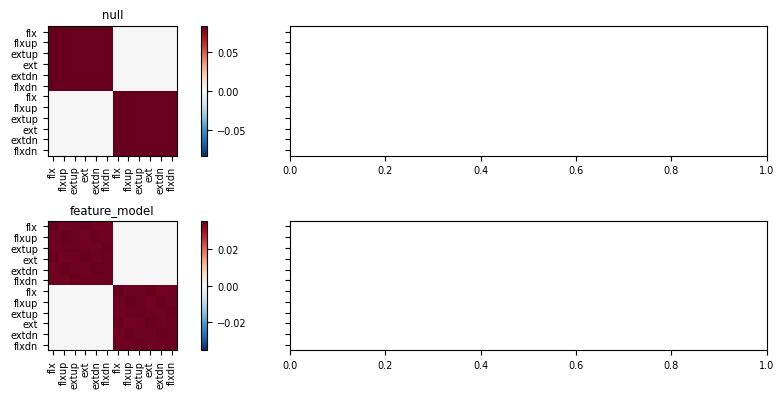

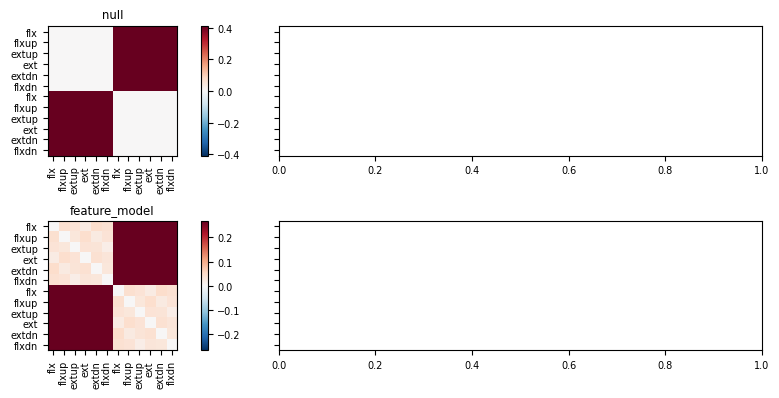

In [83]:
fig, ax = plt.subplots(1,1,figsize=(3,2))
tmp_ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null')
# angle the x axis labels:
plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
ax.set_ylim(-1, 80)
plt.show()

# Plot model predictions:
fig, ax = plt.subplots(2, nmodels//2+1, figsize=(10,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i%2, i//2].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i%2, i//2].set_title(M[i].name)
    ax[i%2, i//2].set_xticks(list(range(12)))
    ax[i%2, i//2].set_xticklabels(labels, rotation=90)
    ax[i%2, i//2].set_yticks(list(range(12)))
    ax[i%2, i//2].set_yticklabels(labels)
    plt.colorbar(ax[i%2, i//2].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i%2, i//2])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2,nmodels//2+1, figsize=(10,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    D = pcm.G_to_dist(G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i%2, i//2].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i%2, i//2].set_title(M[i].name)
    ax[i%2, i//2].set_xticks(list(range(12)))
    ax[i%2, i//2].set_xticklabels(labels, rotation=90)
    ax[i%2, i//2].set_yticks(list(range(12)))
    ax[i%2, i//2].set_yticklabels(labels)
    plt.colorbar(ax[i%2, i//2].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i%2, i//2])
plt.tight_layout()
plt.show()

